In [ ]:
## NEW METHOD
# curl -L "https://drive.usercontent.google.com/download?id=1q5Yp_kNA7gClJyFbOMxRkm12p9Qyjc60&confirm=xxx" -o filename
# https://drive.google.com/file/d/1q5Yp_kNA7gClJyFbOMxRkm12p9Qyjc60/view?usp=sharing
## END NEW METHOD 

In [5]:



# The following is an implementation of a tuning algorithm for Perseus's HCE. Perseus is a open-source chess engine that is written in C++.
# We will get an already exported .bin file containing features extracted from the engine HCE. This way, the optimization problem becomes a simple logistic regression problem.
# The only thing we need to account for is that the linear regression will be done with a slightly modified version of the sigmoid function (with a much larger range),
# since the engine values are expected to vary between -1000 and 1000.
# We will use torch to implement the logistic regression and the optimization algorithm.
# The optimization algorithm will be the AdamW, and we will use weight decay (with a rather small value not to mess the sigmoid scale) to prevent overfitting.
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Open the file containing the features. 
ENTRY_BYTE_SIZE = 480
NUM_FEATURES = ENTRY_BYTE_SIZE - 1

In [ ]:
with open('out.bin', 'rb') as f:
    features = f.read()
    features = np.frombuffer(features, dtype=np.int8)
# Reshape the features to have the correct shape. Do it not as a view, but as a copy.
features = features.reshape(-1, ENTRY_BYTE_SIZE).copy()

# Shuffle the features.
np.random.seed(47) # 47 my beloved.
np.random.shuffle(features)

torch.manual_seed(47) # 47 my sweethearth.

# Split the features into the input and output.
X = features[:, :NUM_FEATURES]
y = features[:, -1]

# Divide the features into training and testing sets.
train_size = int(0.99 * len(X)) # We don't really care about having a big test set, since the real evaluation will be the sprt test of the tuned engine vs the original.
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert both to torch tensors. Also, rescale y to be 0, 0.5 and 1.
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor((y_train + 1) / 2, dtype=torch.float32)
y_test = torch.tensor((y_test + 1) / 2, dtype=torch.float32)

# Unsqueeze the y tensors to have the correct shape (n, 1).
y_train = y_train.unsqueeze(1)
y_test = y_test.unsqueeze(1)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Delete the numpy array to free up memory.
del features
del X
del y

In [ ]:
# Create a dataset class
import torch.utils.data as data
from torch.utils.data import DataLoader

class ChessDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
default = [
    130, 432, 447, 623, 1369,

    -1,    6,    6,    3,    3,    0,    3,    7 ,
      36,   37,   22,   35,   23,   39,   15,   -3 ,
       3,    1,    7,   11,   24,   12,    3,   -5 ,
      -1,   -3,    0,    4,    6,    1,   -4,   -1 ,
      -9,  -11,   -6,    2,    3,    0,   -7,   -1 ,
      -9,   -7,   -9,  -11,   -9,  -16,    8,    3 ,
     -43,  -43,  -28,  -33,  -27,  -17,    9,  -11 ,
      -4,    2,    1,    1,   -1,   -1,   -8,    3 ,

      -158,  -92,  -59,  -10,   23,  -45,  -53,  -85 ,
      14,   43,   72,  102,   70,  167,   38,   59 ,
       5,   51,   66,   94,  164,  151,   97,   58 ,
      15,   21,   50,   91,   58,   94,   46,   84 ,
      -6,    5,   18,   28,   47,   39,   58,   30 ,
     -43,  -19,   -6,    1,   17,    7,   27,    9 ,
     -79,  -62,  -42,  -28,  -12,  -25,   -6,   -4 ,
     -77,  -35,  -42,  -10,   -3,    0,  -30,  -40 ,

     -17,  -40,  -47,  -83,  -63,  -60,  -13,  -35 ,
      18,   50,   28,   29,   60,   57,   34,    1 ,
       1,   30,   36,   66,   63,  112,   70,   56 ,
      -5,   11,   36,   70,   61,   52,   22,   12 ,
      -4,   -4,    7,   44,   45,    6,   10,   39 ,
       4,   35,   14,   12,    7,   19,   52,   35 ,
      -9,  -20,   22,  -31,   -5,    3,   39,   46 ,
       8,   47,    9,   -4,    0,    4,   22,   24 ,

       20,    8,    4,    5,   24,   46,   51,   71 ,
      49,   45,   54,   87,   67,  110,   83,  115 ,
       0,   35,   30,   37,   97,  102,  133,  112 ,
      -3,   11,    8,   14,   17,   28,   49,   60 ,
     -25,  -26,  -22,  -17,  -17,  -30,   26,   24 ,
     -30,  -23,  -28,  -32,  -23,  -16,   58,   27 ,
     -65,  -58,  -31,  -39,  -23,  -23,   26,  -13 ,
     -12,   -8,   -8,    0,   12,   12,   16,   -5 ,

     -20,  -17,   14,   44,   48,   68,   73,   35 ,
      42,    2,   11,   27,   38,   82,   52,  115 ,
      17,   14,    6,   30,   51,  133,  118,  130 ,
       4,   -2,    6,    3,    5,   37,   46,   56 ,
       0,   -9,   -9,   -3,    4,    2,   24,   48 ,
       9,   14,    0,  -13,  -15,    8,   45,   49 ,
     -18,  -23,    2,   -5,   -1,   -2,   28,   54 ,
       2,   19,   21,   23,   17,   -3,   17,   12 ,

      17,   43,   41,    5,   17,   45,   81,   46 ,
      56,  108,   63,   97,   83,  105,  137,  100 ,
      23,  107,   53,   38,   71,  130,  125,   89 ,
      31,   41,   12,  -33,  -26,   19,   43,    3 ,
      19,   20,  -24,  -68,  -61,  -20,  -19,  -50 ,
      49,   77,   -1,  -25,  -24,  -20,   44,   24 ,
     130,   67,   68,   16,   21,   33,  128,  145 ,
     152,  204,  171,   31,  121,   74,  186,  175 ,

     -45, -10, 12, 26, 40, 50, 62, 75, 84,
     -61, -14, 7, 19, 39, 50, 59, 64, 67, 72, 84, 92, 96, 81,
     -10, -8, -3, 0, 6, 6, 8, 14, 20, 35, 37, 41, 46, 57, 47,
     -20, -109, -46, -16, 2, 7, 14, 20, 27, 34, 41, 48, 52, 59, 62, 69, 71, 72, 78, 96, 101, 125, 136, 140, 151, 141, 89, 73, 

     20, 21, 14, 13, 9, 4, 2, 1, 
     0, 2, -20, -20, 20, 62, 79,
     -4, 30, 25, 13, 45, 30, 21, 35,

     # EG
     153, 437, 452, 773, 1379,

     -1,   -8,   -4,   -4,   -2,   -1,   -3,   -6 ,
      53,   50,   46,   40,   43,   39,   44,   54 ,
      30,   29,   25,   17,   16,   19,   23,   25 ,
      16,   14,    3,   -4,   -6,    0,    6,    6 ,
       6,    6,   -6,  -11,   -9,   -7,   -1,   -4 ,
     -21,  -24,  -26,  -22,  -18,  -16,  -24,  -28 ,
     -41,  -44,  -39,  -33,  -35,  -37,  -48,  -56 ,
      -1,   -7,   -4,   -5,   -1,   -2,    2,   -5 ,

      -61,  -19,    5,  -10,   -6,  -36,  -27,  -84 ,
      52,   61,   43,   37,   22,    9,   43,   19 ,
      33,   33,   61,   50,   23,   14,    7,    6 ,
      23,   28,   51,   49,   49,   42,   26,    4 ,
      20,   14,   43,   44,   50,   32,   10,   12 ,
     -27,  -21,  -12,   18,   14,  -11,  -23,  -19 ,
     -50,  -43,  -38,  -28,  -36,  -37,  -50,  -40 ,
     -14,  -10,   -1,   10,   10,   -7,   -4,    6 ,

     19,   26,   21,   26,   20,    7,   11,    2 ,
      57,   62,   60,   49,   35,   44,   55,   49 ,
      56,   47,   48,   25,   24,   32,   33,   40 ,
      28,   32,   26,   41,   27,   29,   21,   22 ,
       8,   21,   33,   31,   28,   24,   15,  -10 ,
     -15,   -4,    2,   13,   24,    8,  -16,  -19 ,
     -33,  -47,  -51,  -15,  -23,  -30,  -33,  -57 ,
       3,   15,   16,   14,   16,   28,    2,  -23 ,

        59,   61,   71,   61,   51,   54,   50,   43 ,
     109,  124,  117,   93,   95,   86,   93,   82 ,
      88,   85,   86,   71,   53,   48,   50,   41 ,
      69,   61,   70,   59,   42,   43,   41,   33 ,
      49,   48,   46,   41,   42,   44,   25,   20 ,
      17,   12,    8,   15,    7,    3,  -30,  -20 ,
     -16,  -14,  -13,   -9,  -23,  -26,  -43,  -41 ,
      35,   25,   33,   20,   11,   22,   12,   18 ,

       54,   64,   84,   77,   85,   73,   38,   54 ,
     106,  148,  161,  166,  182,  144,  133,  130 ,
      89,   96,  143,  144,  151,  131,   96,  102 ,
      73,   91,  101,  130,  149,  132,  131,  115 ,
      51,   80,   83,  115,  112,  110,   94,   88 ,
       4,   31,   47,   62,   75,   69,   41,   25 ,
     -28,  -25,  -18,    0,    1,  -21,  -48,  -63 ,
       7,    5,    8,   27,   18,   15,    1,   -1 ,

       -41,   15,   27,   56,   48,   61,   57,  -38 ,
      96,  143,  140,  128,  146,  160,  155,  119 ,
      88,  129,  145,  148,  156,  151,  148,  100 ,
      56,  102,  130,  140,  141,  138,  117,   78 ,
      31,   76,  109,  130,  131,  112,   92,   65 ,
       1,   34,   63,   86,   87,   77,   47,   26 ,
     -43,   -5,   12,   34,   38,   27,   -5,  -47 ,
     -43,  -24,    3,   34,   10,   28,  -15,  -63 ,

     -76, -5, 31, 45, 57, 73, 71, 68, 52,
     -48, -32, -1, 25, 40, 56, 66, 70, 76, 76, 69, 67, 63, 56,
     -90, 19, 41, 61, 70, 83, 91, 92, 98, 103, 108, 112, 117, 110, 114,
     -12, -78, -69, -51, -19, 9, 48, 78, 98, 107, 118, 128, 140, 149, 158, 159, 175, 181, 184, 179, 184, 170, 165, 158, 156, 145, 116, 105,

    48, 17, 7, 29, 7, 21, 2, 1,
    0, -34, -21, 18, 66, 171, 263,
    8, -2, 9, 4, 97, -8, 20, 30

]

In [4]:
default = torch.tensor(default, dtype=torch.float32).view(1, -1)
print(default.shape)

torch.Size([1, 956])


In [2]:
###### Now we will read the default values for the features. These values are the ones that the engine uses when no tuning is applied.
# with open('default.bin', 'rb') as f:
#     default = f.read()
#     default = np.frombuffer(default, dtype=np.int8)
#     default = default.reshape(-1, NUM_FEATURES)



# Convert to torch tensor.
default = torch.zeros((NUM_FEATURES-1) * 2) #torch.tensor(default, dtype=torch.float32)

def load_model(ptfile):
    model = HCE()
    model.load_state_dict(torch.load(ptfile))
    return model

# Create the model.
class HCE(nn.Module):
    def __init__(self):
        super(HCE, self).__init__()
        self.mgfc = nn.Linear(NUM_FEATURES-1, 1, bias=False)
        self.egfc = nn.Linear(NUM_FEATURES-1, 1, bias=False)
        self.K = 1.5 / 400 # May need tuning, refer to Andrew Grant's Ethereal tuning guide.
        self.default = default
    
    def load_default(self):
        # Default is exactly NUM_FEATURES * 2 long, since it contains both the mg and eg values.
        self.mgfc.weight.data = self.default[:NUM_FEATURES-1].reshape(1, -1)
        self.egfc.weight.data = self.default[NUM_FEATURES-1:].reshape(1, -1)

    def forward(self, x):
        # First, get the game_phase as the first feature. The gamephase is a number between 0-24, which we will scale to 0-1.
        # print("X shape:", x.shape)
        game_phase = x[:, 0] / 24
        # print("Game phase shape:", game_phase.shape)
        x = x[:, 1:]
        # print("X shape after game phase:", x.shape)
        # Calculate mg and eg tapered evals.
        mg = self.mgfc(x * game_phase.unsqueeze(1))
        # print("MG shape:", mg.shape)
        eg = self.egfc(x * (1 - game_phase).unsqueeze(1))
        # print("EG shape:", eg.shape)
        # Calculate the sigmoid.
        return 1 / (1 + torch.exp(-self.K * (mg + eg)))

# Create the model and load the default values.
# model = load_model("runs/modelft3_50.pt")
model = HCE()
model.load_default()

/tmp/ipykernel_474753/1966209966.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ptfile))


In [ ]:
torch.set_float32_matmul_precision('high')
# Only this extra line of code is required to use oneDNN Graph
# torch.jit.enable_onednn_fusion(True)


# Create the dataset and the dataloader. Use large batch size to speed up training and avoid overfitting (this is a very simple problem).
train_dataset = ChessDataset(X_train, y_train)
test_dataset = ChessDataset(X_test, y_test)

BATCH_SIZE = 16384 * 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=30, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=30, pin_memory=True)

# model = load_model("modelMae_121.pt")
# Compile the model.
# model = torch.compile(m)
model = HCE()
# Find the optimal K value.
K = model.find_optimal_k(train_loader)
print("Optimal K value:", K)

# Create the optimizer.
optimizer = optim.SGD(model.parameters(), lr=1, weight_decay=0.001) # We use a bigger than usual learning rate, since the scale of the weights is much larger.

# Create the loss function. The original paper uses MSE.
criterion = nn.MSELoss()

# Create the scheduler.
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

# Train the model.
EPOCHS = 1024



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

# Create the tensorboard writer.
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter(log_dir="logs", flush_secs=10)

import time

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    epoch_start = time.time()
    for i, (X_batch, y_batch) in enumerate(train_loader):
        # print(f"Epoch {epoch}, Batch {i} start                ", end="\r")
        X_batch, y_batch = X_batch.to(device, non_blocking = True), y_batch.to(device, non_blocking = True)
        for param in model.parameters():
            param.grad = None
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        # print(f"Epoch {epoch}, Batch {i} calculate                ", end="\r")
        loss.backward()
        # print(f"Epoch {epoch}, Batch {i} backward                ", end="\r")
        optimizer.step()
        # print(f"Epoch {epoch}, Batch {i} step                ", end="\r")
        
        #if i % 27 == 26:
            # writer.add_scalar('Loss/train', running_loss / 8, epoch * len(train_loader) + i)
            #print(f"(Train) Epoch {epoch}, Batch {i}, Loss: {running_loss / 27}                            ", e
    scheduler.step()
    model.eval()
    running_loss = 0.0
    for i, (X_batch, y_batch) in enumerate(test_loader):
        X_batch, y_batch = X_batch.to(device, non_blocking = True), y_batch.to(device, non_blocking = True)
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        running_loss += loss.item()
    # writer.add_scalar('Loss/test', running_loss / len(test_loader), epoch)
    

    # Save the model.
    torch.save(model.state_dict(), f"runs/modelft_{epoch}.pt")

    epoch_end = time.time()
    print(f"(Test) Epoch {epoch}, Loss: {running_loss / len(test_loader)} Time: {epoch_end - epoch_start} s")

    # Save the optimizer.
    # torch.save(optimizer.state_dict(), f"optimizer_{epoch}.pt")

# Save final model.
torch.save(model.state_dict(), "modelSGD.pt")



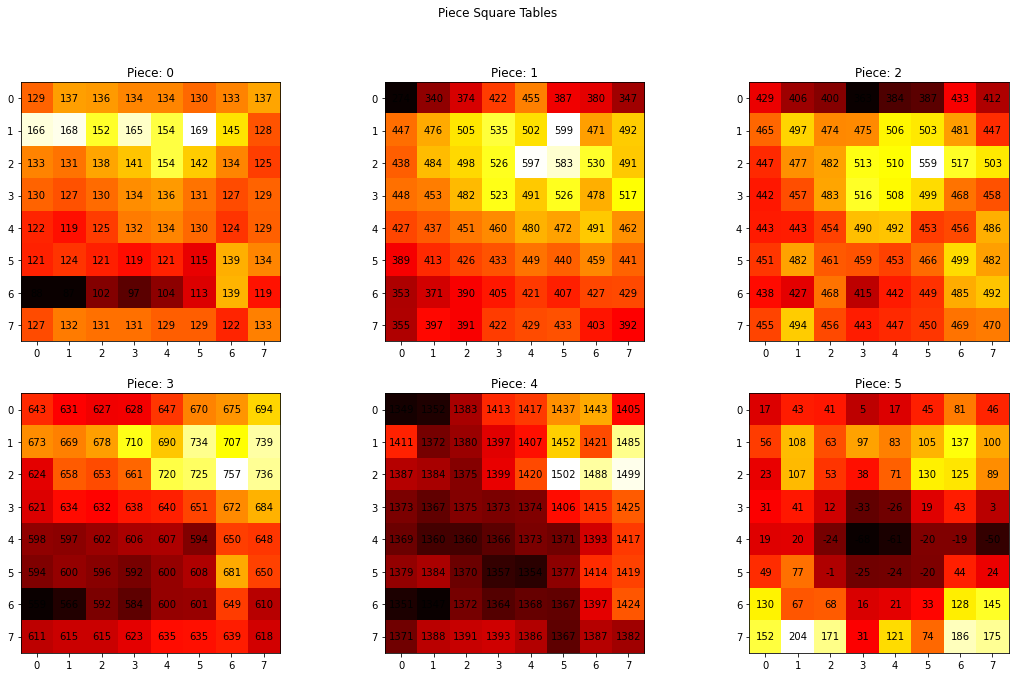

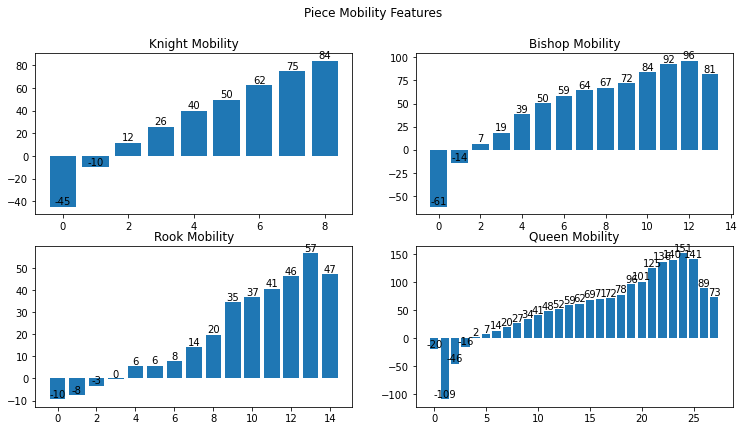

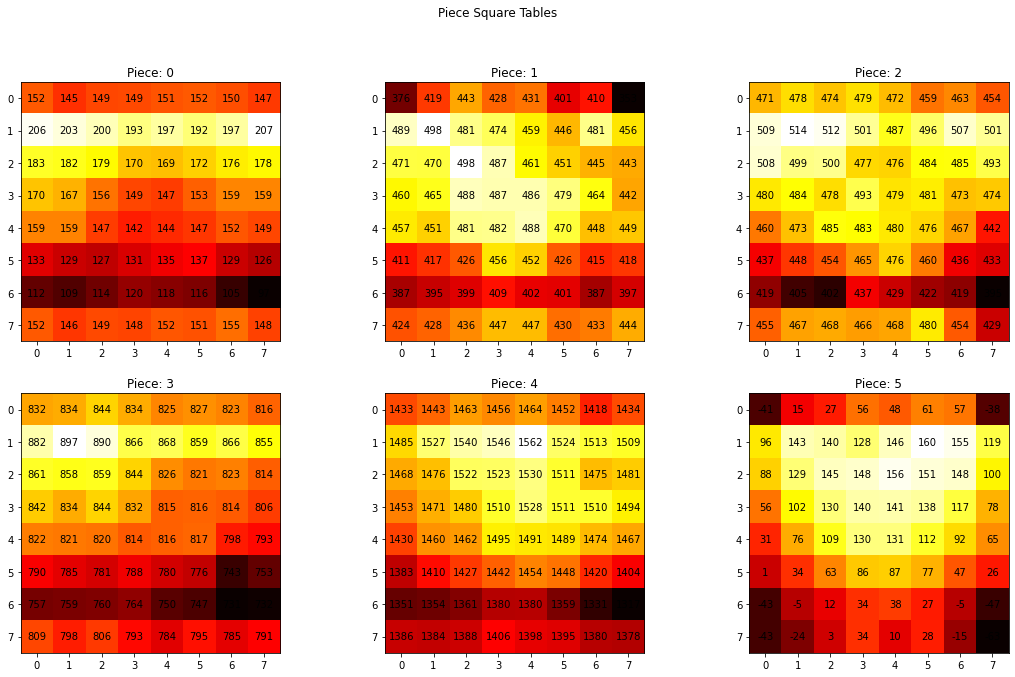

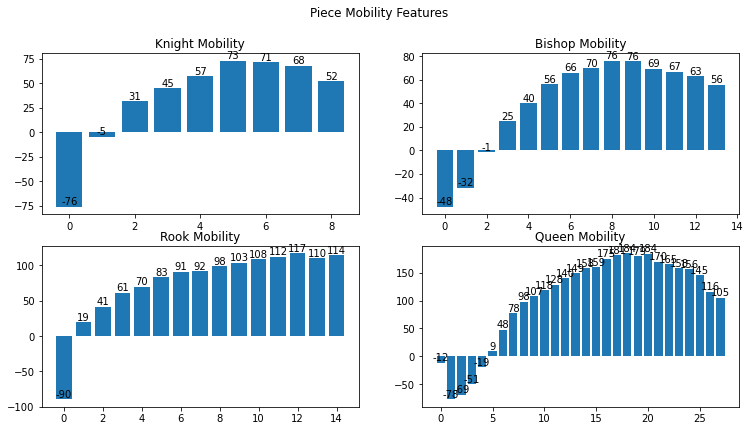

In [3]:
import matplotlib.pyplot as plt
def visualize(model):
    # Visualize the model. The weights are divided in mg and eg.
    # The first 5 weights are the material values.
    # Then, 64 * 6 weights are the piece square tables.
    # Then 9, 14, 15 and 28 piece mobility features.
    # Visualize these weights using matplotlib and heatmaps.
    weights = model.mgfc.weight.data[0]
    # Material values.
    material = weights[:5]
    # Piece square tables.
    pst = weights[5:5+64*6].reshape(6, 64)
    # Piece mobility features.
    knight_mobility = weights[5+64*6:5+64*6+9]
    bishop_mobility = weights[5+64*6+9:5+64*6+9+14]
    rook_mobility = weights[5+64*6+9+14:5+64*6+9+14+15]
    queen_mobility = weights[5+64*6+9+14+15:5+64*6+9+14+15+28]
    # Create the plots. First, plot the psqt. To do this, we need to:
    # Add the material values to the pst (excluding the king).
    pst[0, :] += material[0]
    pst[1, :] += material[1]
    pst[2, :] += material[2]
    pst[3, :] += material[3]
    pst[4, :] += material[4]
    # Now plot the pst.
    fig, axs = plt.subplots(2, 3)
    # Make the figure bigger using figure() method.
    fig.set_size_inches(18.5, 10.5)
    fig.suptitle("Piece Square Tables")
    for i in range(6):
        axs[i//3, i%3].imshow(pst[i].reshape(8, 8), cmap='hot', interpolation='nearest')
        axs[i//3, i%3].set_title("Piece: " + str(i))
        # Add the value text to the plot.
        for y in range(8):
            for x in range(8):
                axs[i//3, i%3].text(x, y, str(round(pst[i, y*8 + x].item())), color='black', ha='center', va='center')
    plt.show()
    # Now show the mobility features. For each piece, plot the mobility features using a bar plot.
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(12.5, 6.5)
    fig.suptitle("Piece Mobility Features")
    axs[0, 0].bar(range(9), knight_mobility)
    axs[0, 0].set_title("Knight Mobility")
    axs[0, 1].bar(range(14), bishop_mobility)
    axs[0, 1].set_title("Bishop Mobility")
    axs[1, 0].bar(range(15), rook_mobility)
    axs[1, 0].set_title("Rook Mobility")
    axs[1, 1].bar(range(28), queen_mobility)
    axs[1, 1].set_title("Queen Mobility")   
    # Add the value text to the plot.
    for i in range(9):
        axs[0, 0].text(i, knight_mobility[i], str(round(knight_mobility[i].item())), color='black', ha='center', va='bottom')
    for i in range(14):
        axs[0, 1].text(i, bishop_mobility[i], str(round(bishop_mobility[i].item())), color='black', ha='center', va='bottom')
    for i in range(15):
        axs[1, 0].text(i, rook_mobility[i], str(round(rook_mobility[i].item())), color='black', ha='center', va='bottom')
    for i in range(28):
        axs[1, 1].text(i, queen_mobility[i], str(round(queen_mobility[i].item())), color='black', ha='center', va='bottom')

    # Now for eg.
    weights = model.egfc.weight.data[0]
    # Material values.
    material = weights[:5]
    # Piece square tables.
    pst = weights[5:5+64*6].reshape(6, 64)
    # Piece mobility features.
    knight_mobility = weights[5+64*6:5+64*6+9]
    bishop_mobility = weights[5+64*6+9:5+64*6+9+14]
    rook_mobility = weights[5+64*6+9+14:5+64*6+9+14+15]
    queen_mobility = weights[5+64*6+9+14+15:5+64*6+9+14+15+28]
    # Create the plots. First, plot the psqt. To do this, we need to:
    # Add the material values to the pst (excluding the king).
    pst[0, :] += material[0]
    pst[1, :] += material[1]
    pst[2, :] += material[2]
    pst[3, :] += material[3]
    pst[4, :] += material[4]
    # Now plot the pst.
    fig, axs = plt.subplots(2, 3)
    # Make the figure bigger using figure() method.
    fig.set_size_inches(18.5, 10.5)
    fig.suptitle("Piece Square Tables")
    for i in range(6):
        axs[i//3, i%3].imshow(pst[i].reshape(8, 8), cmap='hot', interpolation='nearest')
        axs[i//3, i%3].set_title("Piece: " + str(i))
        # Add the value text to the plot.
        for y in range(8):
            for x in range(8):
                axs[i//3, i%3].text(x, y, str(round(pst[i, y*8 + x].item())), color='black', ha='center', va='center')
    plt.show()
    # Now show the mobility features. For each piece, plot the mobility features using a bar plot.
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(12.5, 6.5)
    fig.suptitle("Piece Mobility Features")
    axs[0, 0].bar(range(9), knight_mobility)
    axs[0, 0].set_title("Knight Mobility")
    axs[0, 1].bar(range(14), bishop_mobility)
    axs[0, 1].set_title("Bishop Mobility")
    axs[1, 0].bar(range(15), rook_mobility)
    axs[1, 0].set_title("Rook Mobility")
    axs[1, 1].bar(range(28), queen_mobility)
    axs[1, 1].set_title("Queen Mobility")
    # Add the value text to the plot.
    for i in range(9):
        axs[0, 0].text(i, knight_mobility[i], str(round(knight_mobility[i].item())), color='black', ha='center', va='bottom')
    for i in range(14):
        axs[0, 1].text(i, bishop_mobility[i], str(round(bishop_mobility[i].item())), color='black', ha='center', va='bottom')
    for i in range(15):
        axs[1, 0].text(i, rook_mobility[i], str(round(rook_mobility[i].item())), color='black', ha='center', va='bottom')
    for i in range(28):
        axs[1, 1].text(i, queen_mobility[i], str(round(queen_mobility[i].item())), color='black', ha='center', va='bottom')
    plt.show()
    



visualize(model)

In [4]:
# Print the final weights. Print the weights rounded to 2 decimal places.
p = 5+64*6+9+14+15+28
newliners = [
    5, 5+64*1,5+64*2,5+64*3,5+64*4,5+64*5,5+64*6, 5+64*6+9, 5+64*6+9+14, 5+64*6+9+14+15, 5+64*6+9+14+15+28,
    p+1, p+2, p+3, p+4, p+5, p+6, p+7, p+8,
    p+15, p+16, p+17, p+18, p+19, p+20
]



def psqtprint(numbers, s):# Determine the maximum width of the numbers
    max_width = 4
    
    # Print the numbers with proper formatting
    for i in range(0, len(numbers), 8):
        row = numbers[i:i+8]
        formatted_row = ', '.join(f'{round(num - s):>{max_width}}' for num in row)
        print(f'    {formatted_row} ,')


weights = model.mgfc.weight.data[0]
stuff = []
s = []
for i in range(len(weights)):
    # print(f"{round(weights[i].item())}", end=", ")
    s.append(weights[i].item())
    if i+1 in newliners:
        # print()
        stuff.append(s)
        s = []
stuff.append(s)

heads = ["const Score","constexpr Score"]

names = ["mgValues", "mgPawnTable", "mgKnightTable", "mgBishopTable", "mgRookTable", "mgQueenTable", "mgKingTable", "knightMobMg", "bishopMobMg", "rookMobMg", "queenMobMg",
         "DOUBLEISOLATEDPENMG", "ISOLATEDPENMG", "BACKWARDPENMG", "DOUBLEDPENMG", "SUPPORTEDPHALANXMG", "ADVANCABLEPHALANXMG", "R_SUPPORTEDPHALANXMG", "R_ADVANCABLEPHALANXMG",
         "passedRankBonusMg", "PASSEDPATHBONUSMG", "SUPPORTEDPASSERMG", "BISHOPPAIRMG", "ROOKONOPENFILEMG", "ROOKONSEMIOPENFILEMG", "TEMPOMG"]

for i in range(len(stuff)):
    item = stuff[i]    
    if len(item)==64:
        print(heads[0]+" "+names[i]+" ["+str(len(item))+"] = {\n")
        psqtprint(item, stuff[0][i-1] if i < 6 else 0)
        print("\n};")
    elif len(item)>1:
        print(heads[0]+" "+names[i]+" ["+str(len(item))+"] = {",end = "")
        for x in item:
            print(round(x),end=", ")
        print("};")
    else:
        print(heads[1]+" "+names[i]+" = "+str(round(item[0]))+";")
        

weights = model.egfc.weight.data[0]
stuff = []
s = []
for i in range(len(weights)):
    # print(f"{round(weights[i].item())}", end=", ")
    s.append(weights[i].item())
    if i+1 in newliners:
        # print()
        stuff.append(s)
        s = []
stuff.append(s)

heads = ["const Score","constexpr Score"]

nameseg = ["egValues", "egPawnTable", "egKnightTable", "egBishopTable", "egRookTable", "egQueenTable", "egKingTable", "knightMobEg", "bishopMobEg", "rookMobEg", "queenMobEg",
         "DOUBLEISOLATEDPENEG", "ISOLATEDPENEG", "BACKWARDPENEG", "DOUBLEDPENEG", "SUPPORTEDPHALANXEG", "ADVANCABLEPHALANXEG", "R_SUPPORTEDPHALANXEG", "R_ADVANCABLEPHALANXEG",
         "passedRankBonusEg", "PASSEDPATHBONUSEG", "SUPPORTEDPASSEREG", "BISHOPPAIREG", "ROOKONOPENFILEEG", "ROOKONSEMIOPENFILEEG", "TEMPOEG"]

for i in range(len(stuff)):
    item = stuff[i]    
    if len(item)==64:
        print(heads[0]+" "+nameseg[i]+" ["+str(len(item))+"] = {\n")
        psqtprint(item, stuff[0][i-1] if i < 6 else 0)
        print("\n};")
    elif len(item)>1:
        print(heads[0]+" "+nameseg[i]+" ["+str(len(item))+"] = {",end = "")
        for x in item:
            print(round(x),end=", ")
        print("};")
    else:
        print(heads[1]+" "+nameseg[i]+" = "+str(round(item[0]))+";")


const Score mgValues [5] = {130, 432, 447, 623, 1369, };
const Score mgPawnTable [64] = {

      -1,    6,    6,    3,    3,    0,    3,    7 ,
      36,   37,   22,   35,   23,   39,   15,   -3 ,
       3,    1,    7,   11,   24,   12,    3,   -5 ,
      -1,   -3,    0,    4,    6,    1,   -4,   -1 ,
      -9,  -11,   -6,    2,    3,    0,   -7,   -1 ,
      -9,   -7,   -9,  -11,   -9,  -16,    8,    3 ,
     -43,  -43,  -28,  -33,  -27,  -17,    9,  -11 ,
      -4,    2,    1,    1,   -1,   -1,   -8,    3 ,

};
const Score mgKnightTable [64] = {

    -158,  -92,  -59,  -10,   23,  -45,  -53,  -85 ,
      14,   43,   72,  102,   70,  167,   38,   59 ,
       5,   51,   66,   94,  164,  151,   97,   58 ,
      15,   21,   50,   91,   58,   94,   46,   84 ,
      -6,    5,   18,   28,   47,   39,   58,   30 ,
     -43,  -19,   -6,    1,   17,    7,   27,    9 ,
     -79,  -62,  -42,  -28,  -12,  -25,   -6,   -4 ,
     -77,  -35,  -42,  -10,   -3,    0,  -30,  -40 ,

};
const Score mgBis

In [5]:
# Define the list of numbers
numbers = [
-71, -40, -35, -4, -12, -3, -9, -85, -9, 32, 30, 14, 30, 38, 31, 0, -3, 28, 42, 55, 50, 66, 48, 8, -7, 22, 45, 57, 59, 57, 40, 12, -24, 18, 33, 58, 53, 41, 30, 1, -27, 2, 18, 30, 28, 21, 10, -5, -43, -8, -7, 5, 9, 1, -12, -35, -80, -61, -38, -26, -38, -28, -53, -89, 
]

# Determine the maximum width of the numbers
max_width = max(len(str(num)) for num in numbers)

# Print the numbers with proper formatting
for i in range(0, len(numbers), 8):
    row = numbers[i:i+8]
    formatted_row = ', '.join(f'{num:>{max_width}}' for num in row)
    print(f'    {formatted_row} ,')



    -71, -40, -35,  -4, -12,  -3,  -9, -85 ,
     -9,  32,  30,  14,  30,  38,  31,   0 ,
     -3,  28,  42,  55,  50,  66,  48,   8 ,
     -7,  22,  45,  57,  59,  57,  40,  12 ,
    -24,  18,  33,  58,  53,  41,  30,   1 ,
    -27,   2,  18,  30,  28,  21,  10,  -5 ,
    -43,  -8,  -7,   5,   9,   1, -12, -35 ,
    -80, -61, -38, -26, -38, -28, -53, -89 ,
